In [1]:
# Script para implementar funcionamiento de subprocess lanzado en script principal
# Fecha: 01/01/2025

import sys
import pandas as pd
import os
# módulo para verificar si un path existe
from pathlib import Path

# Módulo para bajer productos S2
sys.path.append(r'../utils')
import mod_dloader as mdl

# Para implementar funciones de snappy en módulo
import mod_snappy_S2 as msnap

# Módulo para graficar
import matplotlib.pyplot as plt

/opt/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


df_path_model = r'/src/Output/Test_Tucu_2_20250101T132641/table/statistics.xls'
output_path = r'/src/Output/Test_Tucu_2_20250101T132641/table/'
df = pd.read_excel(df_path_model)

display(df)

# Función para "Creación de ploteo de serie temporal" a partir de df con fecha de adquisición y valores estadísticos.
# También debe tener como entrada el path donde se guarde el gráfico (/src/Output/Test_Tucu_2_20250101T132641/)
# Plot with Matplotlib
def temp_series(df, path2save, verbose):
    out_path = os.path.join(path2save, 'temporal_series.png')
    plt.figure(figsize=(10, 6))
#     plt.plot(df['acq_date'], df['mean_value'], marker='o', label='mean_NDVI')
    plt.plot(df['acq_date'], df['mean_value'], linestyle='-', marker='o', color='green', label='mean_NDVI')  # Red dashed line
    plt.plot(df['acq_date'], df['cloudCover'],  linestyle='', marker='D', color='blue', label='Product Cloud cover')        # Blue solid 
    plt.title('Temporal Series')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.savefig(out_path , bbox_inches='tight')
    if verbose:
        plt.show()
    return None

def temp_series_2(df, path2save, verbose):
    out_path = os.path.join(path2save, 'temporal_series.png')
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the first column on the primary y-axis
#     ax1.plot(df['acq_date'], df['mean_value'], linestyle='-', marker='o', color='green', label='mean_NDVI')
#     xerr_lower = df['std_dev_value']/2
#     xerr_upper = df['std_dev_value']/2
    ndvi_color = 'green'
    ax1.errorbar(df['acq_date'], df['mean_value'], yerr = df['std_dev_value']/2, linestyle='-', marker='o', color=ndvi_color, label='mean_NDVI')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('NDVI [-]', color=ndvi_color)
    ax1.tick_params(axis='y', labelcolor=ndvi_color)
#     ax1.legend('lower right')
    plt.legend(loc='lower right')

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['acq_date'], df['cloudCover'], linestyle='', marker='D', color='blue', label='Product Cloud cover')
    ax2.set_ylabel('Cloud cover (%)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
#     ax2.legend('lower left')

    # Add titles and grid
    plt.title('Temporal series two axis')
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.grid()
    plt.legend()    
    plt.savefig(out_path , bbox_inches='tight')
    
    if verbose:
        plt.show()
    return None
    

msnap.temp_series_2(df, output_path, True)

# Lectura de producto procesado con baseline N9999

In [2]:
# Celda para acceder al listado de máscaras dentro de un producto en snappy
path2prod2debug = r'/src/Output/Error_N9999_20250111T183824/tmp/S2B_MSIL2A_20190214T141049_N9999_R110_T20JPP_20230425T120610.SAFE.zip'
path2wkt = '../Vectores/aux_wkt/wkt_file.txt'
product_subset = msnap.subset_prod(path2prod2debug, path2wkt, False)

# Aplicación de resize
resamp_prod = msnap.resize(product_subset, 'B2')

# Visualización de máscaras disponibles en producto
vdGroup = resamp_prod.getVectorDataGroup()
for i in range(vdGroup.getNodeCount()):
    print(f'Vector data number {i} = ', vdGroup.get(i).getName())

maskGroup = resamp_prod.getMaskGroup()
for i in range(maskGroup.getNodeCount()):
    print(f'Mask number {i} = ', maskGroup.get(i).getName())

POLYGON ((-61.7044856 -28.7895558, -61.705285 -28.7901389, -61.7080972 -28.7956776, -61.6890472 -28.7966416, -61.6877691 -28.7900652, -61.7044008 -28.7892332, -61.7044856 -28.7895558))
Datos de producto S2 completo
Ancho: 10980 px

Alto: 10980 px

Nombre: S2B_MSIL2A_20190214T141049_N9999_R110_T20JPP_20230425T120610

Cantidad de bandas: 46

Datos de producto S2 recortado
Ancho: 199 px

Alto: 84 px

Nombre: Subset_S2B_MSIL2A_20190214T141049_N9999_R110_T20JPP_20230425T120610

Cantidad de bandas: 46

Vector data number 0 =  pins
Vector data number 1 =  ground_control_points
Vector data number 2 =  detector_footprint-B02-07
Vector data number 3 =  detector_footprint-B02-08
Vector data number 4 =  detector_footprint-B02-09
Vector data number 5 =  detector_footprint-B02-10
Vector data number 6 =  detector_footprint-B02-11
Vector data number 7 =  detector_footprint-B02-12
Vector data number 8 =  detector_footprint-B03-07
Vector data number 9 =  detector_footprint-B03-08
Vector data number 10 =

### Conclusión:

Encuentro que para los productos con procesamiento N9999 los vectores tienen nombre diferente respecto de las máscaras. Agrego este caso en caso de que la aplicación de la máscara de cirros falle.

### Desarrollo posterior

Continuo desarrollando en este notebook la modificación de la función masking del módulo msnap.

In [3]:
def plotRGB(product, title, vmin, vmax):
    band_list = ['B4','B3','B2']
    band_stack = []
    for band in band_list:
        band=product.getBand(band)
        w=band.getRasterWidth()
        h=band.getRasterHeight()
#         depth = 3
        print(w,h)
        band_layer=np.zeros(w*h,np.float32)
        band.readPixels(0,0,w,h,band_layer)
        band_layer.shape=h,w
        band_stack.append(band_layer)
        
    width=12
    height=12
    rgb = np.dstack(band_stack)  # stacks 3 h x w arrays -> h x w x 3
    plt.figure(figsize=(width,height))
    plt.title('Producto de fecha: ' + title, fontweight ="bold") 
    imgplot=plt.imshow(rgb,cmap=plt.cm.binary,vmin=vmin,vmax=vmax)
    plt.savefig('./aux_files/muetra.png', bbox_inches='tight')

    return None

199 84
199 84
199 84


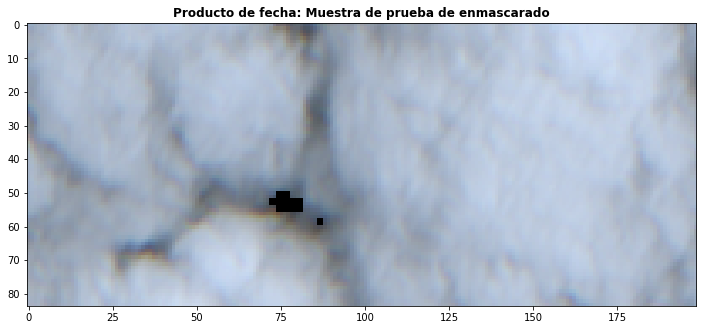

In [5]:
mask = 'cirrus_clouds'
msnap.get_mask_list(resamp_prod, False)
masked_prod = msnap.masking_2(resamp_prod, 'cirrus_clouds', True)
msnap.plotRGB_s2(masked_prod, 'Muestra de prueba de enmascarado', 0, 0.3)
